## DIstributed Shared Nearest Neighbor experiments

In [24]:
if length(workers()) > 1
    println("Removing previous workers...")
    rmprocs(workers())
end


include("/workspace/distributed_clustering/julia/src/dsnn_IO.jl")
# Grancoloso
#addprocs(["158.251.93.5:3308","158.251.93.5:3307","158.251.93.5:3306","158.251.93.5:3305",])
#addprocs(["158.251.93.5:3308","158.251.93.5:3307","158.251.93.5:3306","158.251.93.5:3305",
#        "158.251.93.5:3304","158.251.93.5:3303","158.251.93.5:3302","158.251.93.5:3301",])

# Coloso
#addprocs(["158.251.88.180:3301","158.251.88.180:3302","158.251.88.180:3303","158.251.88.180:3304",])

overall_parameters = DSNN_IO.read_configuration("src/experiments_config");
addprocs(overall_parameters["master.nodelist"]);


@everywhere include("/workspace/distributed_clustering/julia/src/dsnn_IO.jl")
@everywhere include("/workspace/distributed_clustering/julia/src/dsnn_KNN.jl")
@everywhere include("/workspace/distributed_clustering/julia/src/dsnn_SNN.jl")
@everywhere include("/workspace/distributed_clustering/julia/src/dsnn_Master.jl")

using Graphs
using CSV

assert(length(workers()) == length(overall_parameters["master.nodelist"]))

Removing previous workers...


stdin: is not a tty
stdin: is not a tty
stdin: is not a tty
stdin: is not a tty
Type{Graphs.GDistanceVisitor{G, DMap} where DMap where G<:(Graphs.AbstractGraph{V, E} where E where V)})(G<:(Graphs.AbstractGraph{V, E} where E where V), DMapWARNING: Method definition ) in module Graphs at /root/.julia/v0.6/Graphs/src/breadth_first_visit.jl:107 overwritten at /root/.julia/v0.6/Graphs/src/breadth_first_visit.jl:111.
(::Type{Graphs.SourceIterator{G, EList} where EList where G<:(Graphs.AbstractGraph{V, E} where E where V)})(G<:(Graphs.AbstractGraph{V, E} where E where V), EList) in module Graphs at /root/.julia/v0.6/Graphs/src/common.jl:142 overwritten at /root/.julia/v0.6/Graphs/src/common.jl:146.


## Execution of the method

In [25]:
overall_parameters = DSNN_IO.read_configuration("src/experiments_config");
results = Dict{String,Any}();
DATA_PATH = overall_parameters["master.inputpath"];
DATA_LEN, DATA_DIM = DSNN_IO.get_dimensions_from_input_file(DATA_PATH);
partitions = DSNN_Master.generate_partitions(length(workers()), DATA_LEN); # N must be extracted from the data.

println("\n***********************************************************")
DSNN_Master.start(results, DATA_PATH, partitions, overall_parameters);
#storing final result
writedlm(@sprintf("%s.dsnnfinal.labels",DATA_PATH), results["stage2_labels"], "\n");


***********************************************************
[M] Starting Stage 1 (assignment distribution and corepoint identification)
	From worker 23:	[W] executing snn clustering with eps:0.9 and minpts:13
	From worker 22:	[W] executing snn clustering with eps:0.9 and minpts:13
	From worker 24:	[W] executing snn clustering with eps:0.9 and minpts:13
	From worker 25:	[W] executing snn clustering with eps:0.9 and minpts:13
[M] Joining worker's results of Stage 1
Amount of noisy data points detected by worker 4:450
Amount of noisy data points detected by worker 2:451
Amount of noisy data points detected by worker 3:317
Amount of noisy data points detected by worker 5:507
[M] Corepoints (217) and Samples (888)
[M] Grouping selected corepoints and sampled data by applying SNN clustering
[M] Retransmitting overall corepoints (Stage 2)...
	From worker 24:	[W] Labeling assigned instances from the oveall corepoints
	From worker 22:	[W] Labeling assigned instances from the oveall corepoints


In [27]:
# Applying SNN-Clustering overthe corepoints
@time begin
    println("Applying SNN-Clustering over the corepoints...");
    cp_results = DSNN_SNN.snn_clustering(overall_parameters["corepoint.eps"], overall_parameters["corepoint.minpts"], adj_mat);

    labels_found = fill(0, size(cp_results["labels"],1));
    for c in collect(1:size(cp_results["labels"],2))
        for i in cp_results["labels"][:,c].nzind
            labels_found[i] = cp_results["clusters"][c]; # extract the right assigned label name
        end
    end

    println("Num. Clusters found:",length(unique(labels_found)))
    if length(find(x->x<0, cp_results["clusters"])) > 0
        println(@sprintf("Percentage of noise:: %0.2f", 
                length(cp_results["labels"][:,1].nzind)/size(cp_results["labels"],1)))
    else
        println("Amount of noise: 0");
    end
    writedlm(@sprintf("%s.corepoints.snn.labels",DATA_PATH), labels_found, "\n");
end

# Applying Connected components
@time begin
    println("Applying Connected Components over the corepoints...");
    numpoints = size(Dw,2);
    println("Num. points:",numpoints);

    G = Graphs.simple_adjlist(numpoints, is_directed=false);
    for i in collect(1:numpoints)
        for j in adj_mat[:,i].nzind
            Graphs.add_edge!(G, i, j)
        end
    end

    cmps = Graphs.connected_components(G);

    println("Num. connected components:",length(cmps));
    labels_found = fill(-1, numpoints);
    for cmp_i in eachindex(cmps)
        for p in cmps[cmp_i]
            labels_found[p] = cmp_i;
        end
    end
    println("Num. Clusters found:",length(unique(labels_found)))
    writedlm(@sprintf("%s.corepoints.conncomps.labels",DATA_PATH), labels_found, "\n");

end

# Applying Maximal Clique to the corepoints
@time begin
    println("Applying Maximal Clique over the corepoints...");
    numpoints = size(Dw,2);
    println("Num. points:",numpoints);

    G = Graphs.simple_adjlist(numpoints, is_directed=false);
    for i in collect(1:numpoints)
        for j in adj_mat[:,i].nzind
            Graphs.add_edge!(G, i, j)
        end
    end

    cmps = Graphs.maximal_cliques(G);

    println("Num. Cliques:",length(cmps));
    labels_found = fill(-1, numpoints);
    for cmp_i in eachindex(cmps)
        for p in cmps[cmp_i]
            labels_found[p] = cmp_i;
        end
    end

    println("Num. Clusters found:",length(unique(labels_found)))
    writedlm(@sprintf("%s.corepoints.cliques.labels",DATA_PATH), labels_found, "\n");

end

# Applying Label propagation to the corepoints
@time begin
    println("Applying Label propagation over the corepoints...")
    using LightGraphs

    G = LightGraphs.Graph(numpoints)
    for i in collect(1:numpoints)
       for j in adj_mat[:, i].nzind
           if j > i 
               # maybe a threshold based on adj_mat[j,i] could be used !
               if ~LightGraphs.add_edge!(G, i, j)
                   println("[M] Error: Cannot add edge between vertices ",i," and ",j)
               end
           end
       end
    end
    labels_found, conv_history = LightGraphs.label_propagation(G);
    println("Num. Clusters found:",length(unique(labels_found)))
    writedlm(@sprintf("%s.corepoints.lblprop.labels",DATA_PATH), labels_found, "\n");

end


# Applying DBSCAN over the corepoints
@time begin
    println("Applying DBSCAN over the corepoints...");
    using Clustering

    #dbscan_cl = Clustering.dbscan(full(Dw), 0.1, min_neighbors=15);
    dbscan_cl = Clustering.dbscan(full(1.0 .- adj_mat), overall_parameters["corepoint.dbscan.eps"], overall_parameters["corepoint.dbscan.minpts"]);
    labels_found = dbscan_cl.assignments;
    println("Num. Clusters found:",length(unique(labels_found)))
    writedlm(@sprintf("%s.corepoints.dbscan.labels",DATA_PATH), labels_found, "\n");
end

println("\n########################################################\n")
run(`python src/evaluate_corepoint_files.py -i $DATA_PATH -f rst`)

Applying SNN-Clustering over the corepoints...
Num. Clusters found:15
Percentage of noise:: 0.06
  0.022289 seconds (6.70 k allocations: 562.533 KiB)
Applying Connected Components over the corepoints...
Num. points:207
Num. connected components:3
Num. Clusters found:3
  0.036822 seconds (18.44 k allocations: 918.500 KiB)


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Int64}, ::Int64) at ./deprecated.jl:57
 [3] Type at /root/.julia/v0.6/Graphs/src/graph_visit.jl:44 [inlined]
 [4] connected_components(::Graphs.GenericAdjacencyList{Int64,UnitRange{Int64},Array{Array{Int64,1},1}}) at /root/.julia/v0.6/Graphs/src/connected_components.jl:20
 [5] macro expansion at ./In[27]:36 [inlined]
 [6] macro expansion at ./util.jl:237 [inlined]
 [7] anonymous at ./<missing>:?
 [8] include_string(::String, ::String) at ./loading.jl:515
 [9] include_string(::Module, ::String, ::String) at /root/.julia/v0.6/Compat/src/Compat.jl:478
 [10] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /root/.julia/v0.6/IJulia/src/execute_request.jl:154
 [11] eventloop(::ZMQ.Socket) at /root/.julia/v0.6/IJulia/src/eventloop.jl:8
 [12] (::IJulia.##14#17)() at ./task.jl:335
while loading In[27], in expression starting on line 24


Applying Maximal Clique over the corepoints...
Num. points:207
Num. Cliques:110
Num. Clusters found:52
  0.038876 seconds (49.06 k allocations: 4.599 MiB, 23.88% gc time)
Applying Label propagation over the corepoints...
Num. Clusters found:8
  0.005420 seconds (10.24 k allocations: 686.219 KiB)
Applying DBSCAN over the corepoints...
Num. Clusters found:4
  0.090978 seconds (15.61 k allocations: 1.882 MiB)

########################################################

Evaluating over corepoints generated from data file /workspace/cure_large.dat
===================  =========  ========  ========
Method                 V-Score       ARI       AMI
===================  =========  ========  ========
D-SNN (all)           0.396865  0.216107  0.274416
SNN (cpts)            0.445851  0.112795  0.270516
Conn. Comps. (cpts)   0.771636  0.782328  0.647095
Max Cliques (cpts)    0.38447   0.049445  0.15681
Label Prop. (cpts)    0.510043  0.202564  0.360754
DBSCAN (cpts)         0.753423  0.765317  0.67

[Only for small 2D data] Plotting corepoints and whole dataset



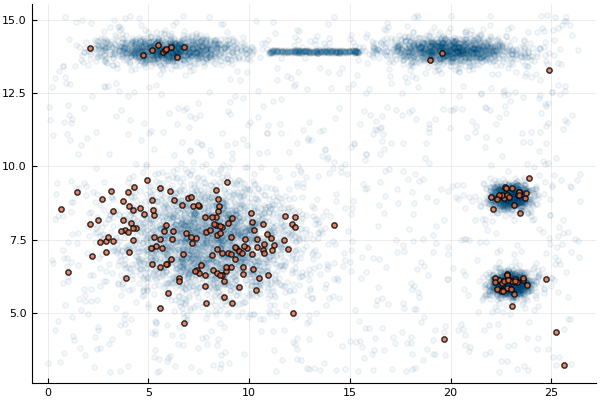

In [17]:
# Experimentation over the obtained corepoints
D = DSNN_IO.sparseMatFromFile(DATA_PATH, l2normalize=true);
real_labels = vec(readdlm(@sprintf("%s.labels",DATA_PATH), Int32));
Dw = D[:,results["stage1_corepoints"]];
cp_real_labels = real_labels[results["stage1_corepoints"]];

CSV.write(@sprintf("%s.corepoints.csv",DATA_PATH), DataFrames.DataFrame(full(transpose(Dw))), delim=' ',  header=false);
writedlm(@sprintf("%s.corepoints.labels",DATA_PATH), cp_real_labels, "\n");

snnmat, knnmat = DSNN_KNN.get_snnsimilarity(Dw, overall_parameters["corepoint.knn"], l2knng_path=overall_parameters["l2knng.path"]);

adj_mat = snnmat;
if overall_parameters["corepoint.use_snngraph"]
    snngraph = DSNN_KNN.get_snngraph(knnmat, snnmat);
    adj_mat = snngraph;
end

if size(Dw,1) == 2
    println("[Only for small 2D data] Plotting corepoints and whole dataset")
    using Plots
    pyplot()
    D_raw = DSNN_IO.sparseMatFromFile(DATA_PATH, l2normalize=false);

    colors = fill(1, size(D,2));
    colors[results["stage1_corepoints"]] = 2;
    plt = scatter(D_raw[1,:], D_raw[2,:], marker=(0.05,:o,4), legend=false, fmt = :png)
    scatter!(plt, D_raw[1,results["stage1_corepoints"]], D_raw[2,results["stage1_corepoints"]], marker=(0.8,:o,4), legend=false, fmt = :png)
end

In [ ]:
l_methods = ["snn", "conncomps", "cliques", "lblprop", "dbscan"];
labels_found = fill(-1, (size(Dw,2),length(l_methods)));
for meth_i in collect(1:length(l_methods))
    meth = l_methods[meth_i];
    println("opening ",meth)
    labels_found[:,meth_i] = vec(readdlm(@sprintf("%s.corepoints.%s.labels",DATA_PATH, meth), Int32));
end

Plots.scatter(D_raw[1,results["stage1_corepoints"]], D_raw[2,results["stage1_corepoints"]], layout=5, marker=(0.5,:o,4), group=labels_found[:,1], legend=false, fmt = :png, title=@sprintf("Method %s", l_methods[1]))
Plots.scatter!(D_raw[1,results["stage1_corepoints"]], D_raw[2,results["stage1_corepoints"]], titlefont = font(8), marker=(0.5,:o,4), group=labels_found[:,2], legend=false, fmt = :png, title=@sprintf("Method %s", l_methods[2]))
Plots.scatter!(D_raw[1,results["stage1_corepoints"]], D_raw[2,results["stage1_corepoints"]], titlefont = font(8), marker=(0.5,:o,4), group=labels_found[:,3], legend=false, fmt = :png, title=@sprintf("Method %s", l_methods[3]))
Plots.scatter!(D_raw[1,results["stage1_corepoints"]], D_raw[2,results["stage1_corepoints"]], titlefont = font(8), marker=(0.5,:o,4), group=labels_found[:,4], legend=false, fmt = :png, title=@sprintf("Method %s", l_methods[4]))
Plots.scatter!(D_raw[1,results["stage1_corepoints"]], D_raw[2,results["stage1_corepoints"]], titlefont = font(8), marker=(0.5,:o,4), group=labels_found[:,5], legend=false, fmt = :png, title=@sprintf("Method %s", l_methods[5]))

The _start_ method sets the value of the dictionary _results_ by adding the following values:

* stage1_corepoints: Union of all corepoints identified by the Workers.
* stage1_sampled: Union of all the data points sampled by the Workers.
* stage1_graph: SNN Graph built with __all__ the data returned by the Workers.
* stage2_labels: Labels generated by the Workers after _stage 2_.

## Final result


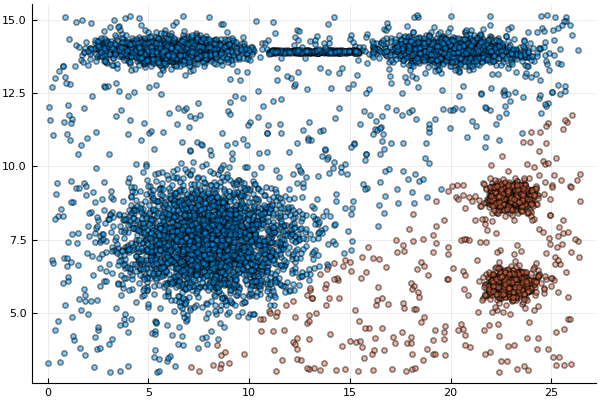

In [23]:
using Plots
pyplot()
D = DSNN_IO.sparseMatFromFile(DATA_PATH, l2normalize=false);
nonnoise = find(x->x>0,results["stage2_labels"]);
plt = scatter(D[1,nonnoise], D[2,nonnoise], marker=(0.5,:o,4), group=results["stage2_labels"][nonnoise], legend=false, fmt = :png)

### ... END of grouping over corepoints